# 14_promoter_promoter
4/6/2021

corresponds to new fig 2F
A. promoter promoter: Basically for a promoter-promoter loop, we want to know if both genes are being expressed in the loop or if one is acting purely as an enhancer and it's own gene is not being expressed

new fig 2G
correlate # loops with target gene expression


In [1]:
import pandas as pd
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

save_dir = '../data/processed/fig2'

In [2]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal',
'GDSD0',
'GDSD3',
'GDSD6',
'GM12878',
'HMEC',
'Melanocytes',
'Ovarian',
'Pancreas',
'Prostate',
'Renal',
'Thyroid',
'Uterine']



In [3]:
loop_files = glob.glob('../data/interim/merged/loops/*csv')
loop_files

['../data/interim/merged/loops/Prostate.loops.csv',
 '../data/interim/merged/loops/HMEC.loops.csv',
 '../data/interim/merged/loops/Astrocytes.loops.csv',
 '../data/interim/merged/loops/COLO_SCR_PLX.loops.csv',
 '../data/interim/merged/loops/COLO_shMITF_PLX.loops.csv',
 '../data/interim/merged/loops/COLO_shMITF_DMSO.loops.csv',
 '../data/interim/merged/loops/Melanocytes.loops.csv',
 '../data/interim/merged/loops/Bladder.loops.csv',
 '../data/interim/merged/loops/Uterine.loops.csv',
 '../data/interim/merged/loops/COLO_SCR_DMSO.loops.csv',
 '../data/interim/merged/loops/Pancreas.loops.csv',
 '../data/interim/merged/loops/WM_SCR_DMSO.loops.csv',
 '../data/interim/merged/loops/Ovarian.loops.csv',
 '../data/interim/merged/loops/CAL27-CTRLi.loops.csv',
 '../data/interim/merged/loops/GDSD6.loops.csv',
 '../data/interim/merged/loops/SCC13-CTRLi.loops.csv',
 '../data/interim/merged/loops/GDSD0.loops.csv',
 '../data/interim/merged/loops/Airway.loops.csv',
 '../data/interim/merged/loops/WM_shMITF_

In [4]:
promoter_anchor_files = glob.glob('../data/interim/annon/promoter_anchors/*bed')
promoter_anchor_files

['../data/interim/annon/promoter_anchors/promoter_Melanocytes_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_WM_shMITF_DMSO_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_D3-CTRLi_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_COLO_shMITF_DMSO_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_Astrocytes_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_COLO_SCR_DMSO_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_WM_SCR_DMSO_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_D3-p63i_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_GM12878_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_CAL27-CTRLi_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_Thyroid_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_HMEC_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_SCC13-CTRLi_annon.bed',
 '../data/interim/annon/promoter_anchors/promoter_A

In [5]:
rna_df = pd.read_csv('../data/interim/rna/tissue_tpm_sym.csv',index_col=0)
print(rna_df.columns)
rna_df[:5]
def get_exp(gene, tissue):
    try:
        return rna_df.loc[gene, tissue]
    except:
        return 0
    
# colnames(rna_df)

Index(['A431-CTRLi', 'A431-p63i', 'Airway', 'Astrocytes', 'Bladder',
       'CAL27-CTRLi', 'CAL27-p63i', 'COLO_SCR_DMSO', 'COLO_SCR_PLX',
       'COLO_shMITF_DMSO', 'COLO_shMITF_PLX', 'Colon', 'D0-CTRLi', 'D0-p63i',
       'D3-CTRLi', 'D3-p63i', 'Esophageal', 'GDSD0', 'GDSD3', 'GDSD6',
       'GM12878', 'HMEC', 'Melanocytes', 'Ovarian', 'Pancreas', 'Prostate',
       'Renal', 'SCC13-CTRLi', 'SCC13-p63i', 'SKMEL5_SCR_DMSO',
       'SKMEL5_SCR_PLX', 'SKMEL5_shMITF-DMSO', 'SKMEL5_shMITF_PLX', 'Thyroid',
       'Uterine', 'WM_SCR_DMSO', 'WM_SCR_PLX', 'WM_shMITF_DMSO',
       'WM_shMITF_PLX'],
      dtype='object')


In [6]:
file = promoter_anchor_files[0]
tissue = os.path.basename(file).split('_')[1]
print(tissue)
p_anchor_df = pd.read_table(file,header=None)
p_anchor_df.columns = ['chr_g','start_g','stop_g',
                                              'gene','chr_a','start_a','stop_a',
                                               'anchor_name','dist']
p_anchor_df['tpm'] = p_anchor_df.gene.apply(lambda g: get_exp(g, tissue))
p_anchor_df = p_anchor_df[['anchor_name','gene','tpm']]
loop_file = os.path.join('../data/interim/merged/loops/',tissue+'.loops.csv')
loop_df = pd.read_csv(loop_file, index_col=0)

Melanocytes


In [7]:
# promoter loop = loop with a gene in both anchor sides
loop_df = (loop_df
    .merge(p_anchor_df,how='left', left_on='source',right_on='anchor_name' )
    .merge(p_anchor_df, how='left', left_on='target',right_on='anchor_name' )
    .dropna()
)

In [8]:
def get_type(row, thres=1):
    """
    types:
    1: both promoters are expression
    2: only one promoter is expressed
    3: no promoters are expressed
    """
    if row['tpm_x']>thres:
        if row['tpm_y']>thres:
            return 1
        else:
            return 2
    else:
        if row['tpm_y']>thres:
            return 2
        else:
            return 3

loop_df['P_P_type'] = loop_df.apply(get_type,axis=1)

In [9]:
tissue_P_P_counts = pd.DataFrame(loop_df.P_P_type.value_counts().sort_index()).T
tissue_P_P_counts.index = [tissue]
tissue_P_P_counts

,1,2,3
Melanocytes,1323,1717,839


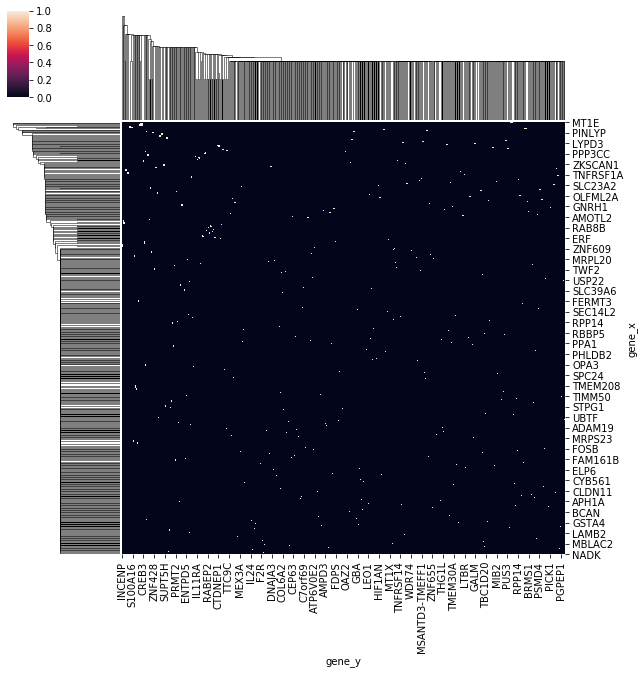

In [10]:
sns.clustermap(loop_df[['gene_x','gene_y','P_P_type']][loop_df.P_P_type==1]
               .drop_duplicates()
               .pivot(index='gene_x',columns='gene_y',values='P_P_type')
               .fillna(0))

In [39]:
def get_first_gene(row):
    if row['gene_x']<row['gene_y']:
        return row['gene_x']
    else:
        return row['gene_y']
    
def get_second_gene(row):
    if row['gene_x']==row['gene_1']:
        return row['gene_y']
    else:
        return row['gene_x']

In [37]:
%%time
tissue_P_P_counts_all = pd.DataFrame()
tissue_P_P_gene_df_all = pd.DataFrame()

for file in sorted(promoter_anchor_files):
    tissue = os.path.basename(file).split('_')[1]
    if tissue not in normal_tissues:
        continue
    print(tissue)
    # get anchor to gene annotation and annotate with correct tissue tpm
    p_anchor_df = pd.read_table(file,header=None)
    p_anchor_df.columns = ['chr_g','start_g','stop_g',
                                                  'gene','chr_a','start_a','stop_a',
                                                   'anchor_name','dist']
    p_anchor_df['tpm'] = p_anchor_df.gene.apply(lambda g: get_exp(g, tissue))
    p_anchor_df = p_anchor_df[['anchor_name','gene','tpm']]
    
    # add to looping information
    loop_file = os.path.join('../data/interim/merged/loops/',tissue+'.loops.csv')
    loop_df = pd.read_csv(loop_file, index_col=0)
    # promoter loop = loop with a gene in both anchor sides
    loop_df = (loop_df
        .merge(p_anchor_df,how='left', left_on='source',right_on='anchor_name' )
        .merge(p_anchor_df, how='left', left_on='target',right_on='anchor_name' )
        .dropna()
        )
    # get P-P type info 1: both exp, 2: one gene exp, 3: no gene exp
    loop_df['P_P_type'] = loop_df.apply(get_type,axis=1)
    loop_df['gene_1'] = loop_df.apply(get_first_gene,axis=1)
    loop_df['gene_2'] = loop_df.apply(get_second_gene,axis=1)
    loop_df_sel = loop_df[['gene_1', 'gene_2', 'P_P_type']]
    loop_df_sel['tissue'] = tissue
    
    # add info to global table 
    loop_1= loop_df[['count','gene_x','tpm_x']]
    loop_1.columns = ['count','gene','tpm']
    loop_2= loop_df[['count','gene_y','tpm_y']]
    loop_2.columns = ['count','gene','tpm']
    loop_bi = (pd.concat([loop_1, loop_2])
                .groupby('gene').agg({'tpm':min, 'count':['count','sum']})
                .reset_index())
    loop_bi.columns = ['gene','tpm','num_loops','loop_count']
    loop_bi['log_tpm'] = np.log10(loop_bi.tpm+1)
    loop_bi['log_loop_count'] = np.log10(loop_bi.loop_count+1)
    
    
    # add count info
    tissue_P_P_counts = pd.DataFrame(loop_df.P_P_type.value_counts().sort_index()).T
    tissue_P_P_counts.index = [tissue]
    tissue_P_P_counts_all = pd.concat([tissue_P_P_counts_all, tissue_P_P_counts])
    
    # add gene pairs info
    tissue_P_P_gene_df_all = pd.concat([tissue_P_P_gene_df_all, loop_df_sel])

Airway


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Astrocytes
Bladder
Colon
Esophageal
GDSD0
GDSD3
GDSD6
GM12878
HMEC
Melanocytes
Ovarian
Pancreas
Prostate
Renal
Thyroid
Uterine


In [38]:
# loop_1 = loop_df[['anchor_name_x','P_P_type', 'tpm_x']]
# loop_1.columns = ['anchor_name','P_P_type', 'tpm']
# loop_2= loop_df[['anchor_name_y','P_P_type', 'tpm_y']]
# loop_2.columns = ['anchor_name','P_P_type', 'tpm']
# loop_bi_anchor = (pd.concat([loop_1, loop_2])
#             .groupby('anchor_name').agg({'P_P_type':['count','min','median','mean','std','max'],
#                                         'tpm':['min','median','mean','std','max']})
#                 .reset_index()
#                  .fillna(0))
# loop_bi_anchor.columns = ['anchor_name',
#                           'count_P_P','min_type','median_type','mean_type','std_type','max_type',
#                          'min_tpm','median_tpm','mean_tpm','std_tpm','max_tpm']
# loop_bi_anchor.plot.scatter(x='max_type',y='mean_type')
# loop_bi_anchor.plot.scatter(x='min_tpm',y='max_type')

In [14]:
tissue_P_P_counts_all['tot_P_P'] = tissue_P_P_counts_all.sum(axis=1)

In [15]:
print(tissue_P_P_counts_all.sum(axis=0))
tissue_P_P_counts_all.sum(axis=0).div(tissue_P_P_counts_all.tot_P_P.sum())

1           55033
2           78668
3           38062
tot_P_P    171763
dtype: int64


1          0.320401
2          0.458003
3          0.221596
tot_P_P    1.000000
dtype: float64

In [16]:
tissue_P_P_counts_all.columns = ['both_exp','one_exp','none_exp','total_P_P']
tissue_P_P_counts_all.to_csv(os.path.join(save_dir,'tissue_P_P_counts_all.csv' ))

In [17]:
tissue_P_P_counts_all

,both_exp,one_exp,none_exp,total_P_P
Airway,943,1165,597,2705
Astrocytes,2175,3094,1362,6631
Bladder,1986,3093,1604,6683
Colon,5248,7829,3895,16972
Esophageal,4108,5852,3080,13040
GDSD0,2697,4045,2070,8812
GDSD3,3085,4391,1925,9401
GDSD6,3521,5080,2231,10832
GM12878,3886,5084,2929,11899
HMEC,1821,2743,1253,5817


In [41]:
tissue_P_P_gene_df_all.to_csv(os.path.join(save_dir,'tissue_P_P_gene_df_all.csv' ))

In [47]:
# tissue_P_P_gene_df_all.pivot(index=['gene_1','gene_2'], values='P_P_type', columns='tissue')

# does # loops correlate with expression
no...

,gene,tpm,num_loops,loop_count,log_tpm,log_loop_count
0,A4GALT,7.325,4,99,0.920384,2.000000
1,AAAS,3.600,3,65,0.662758,1.819544
2,AADAC,0.015,1,11,0.006466,1.079181
3,AAMP,42.070,1,31,1.634175,1.505150
4,AANAT,0.000,4,149,0.000000,2.176091


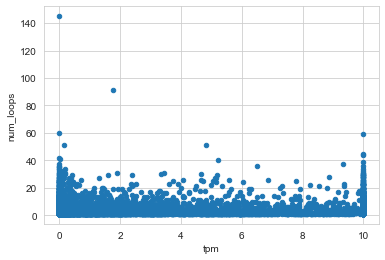

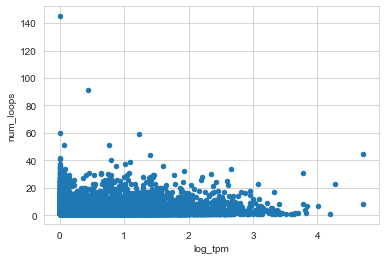

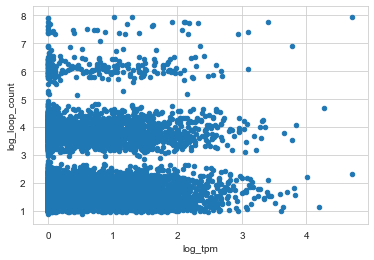

In [182]:
loop_1= loop_df[['count','gene_x','tpm_x']]
loop_1.columns = ['count','gene','tpm']
loop_2= loop_df[['count','gene_y','tpm_y']]
loop_2.columns = ['count','gene','tpm']
loop_bi = (pd.concat([loop_1, loop_2])
            .groupby('gene').agg({'tpm':min, 'count':['count','sum']})
            .reset_index())
loop_bi.columns = ['gene','tpm','num_loops','loop_count']
loop_bi['log_tpm'] = np.log10(loop_bi.tpm+1)
loop_bi['log_loop_count'] = np.log10(loop_bi.loop_count+1)
display(loop_bi[:5])
# loop_bi = loop_bi[(loop_bi.tpm>1) & (loop_bi.loop_count>0)]
loop_bi['tpm'] = loop_bi.tpm.clip(0,10)
loop_bi['loop_count'] = loop_bi.loop_count.clip(0,100)
loop_bi.plot.scatter(x='tpm',y='num_loops')
loop_bi.plot.scatter(x='log_tpm',y='num_loops')
loop_bi.plot.scatter(x='log_tpm',y='log_loop_count')

In [52]:
%%time
data_all = pd.read_csv('../data/processed/tissue_crms/all_count_comb_overall.csv')
data_all[:5]

,Unnamed: 0,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
0,A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,102.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
data_all = data_all.iloc[:,[0,1,2,3,4]]
data_all.columns = ['gene','tissue','tpm','num_loop_counts', 'num_loops']
data_all = data_all.fillna(0)
data_all.sort_values('gene',inplace=True)

In [155]:
sns.set_style("whitegrid")
def get_scatter_gene(gene, df=data_all, get_text=False):
    df_sel = df[df.gene==gene].reset_index()
    ax = sns.scatterplot(data=df_sel, x='tpm',y='num_loops')
    if get_text:
        added_x = max(df_sel.tpm)/10
        for line in range(0,df_sel.shape[0]):
             plt.text(df_sel.tpm[line]+added_x, df_sel.num_loops[line], df_sel.tissue[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    ax.set_xlabel('TPM')
    ax.set_ylabel('# loops')
    ax.set_title('Loop-expression correlation: '+ gene)
    plt.show()
    return df_sel

def get_per_gene_r(gene, df=data_all):
    df_sel = df[df.gene==gene].reset_index()
    r =  np.corrcoef(df_sel.tpm, df_sel.num_loops)[0,1]
    if np.isnan(r):
        return 0
    return r

In [89]:
data_all[(data_all.tpm>20)&(data_all.tissue=='GDSD6')].gene.unique()#.shape

array(['A2ML1', 'AAGAB', 'AAK1', ..., 'ZNF830', 'ZRANB2', 'ZSWIM7'],
      dtype=object)

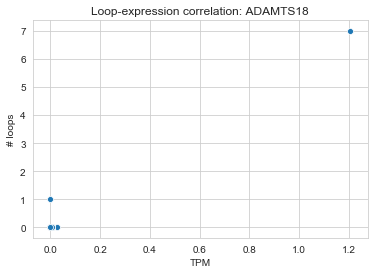

In [153]:
df_sel = get_scatter_gene('ADAMTS18')

In [151]:
df_sel = data_all[data_all.gene=='ADAMTS13'].reset_index()
display(df_sel)
np.corrcoef(df_sel.tpm, df_sel.num_loops)

,index,gene,tissue,tpm,num_loop_counts,num_loops
0,446894,ADAMTS13,GDSD3,0.275,14.0,1.0
1,546138,ADAMTS13,Melanocytes,0.100,24.0,2.0
2,496516,ADAMTS13,GM12878,0.025,13.0,1.0
3,347650,ADAMTS13,D3-CTRLi,0.450,0.0,0.0
4,273217,ADAMTS13,Colon,0.100,40.0,3.0
5,223595,ADAMTS13,COLO_shMITF_DMSO,0.105,0.0,0.0
6,397272,ADAMTS13,Esophageal,0.095,1125.0,2.0
7,645382,ADAMTS13,Renal,0.100,19.0,2.0
8,25107,ADAMTS13,A431-p63i,0.060,40.0,4.0
9,744626,ADAMTS13,Uterine,0.000,78.0,4.0


array([[ 1.        , -0.06186319],
       [-0.06186319,  1.        ]])

In [113]:
%%time
corr_df = pd.DataFrame()
corr_df['gene'] = data_all.gene.unique()
corr_df['r'] = corr_df.gene.apply(get_per_gene_r)

CPU times: user 13min 31s, sys: 1.76 s, total: 13min 33s
Wall time: 13min 34s


In [114]:
corr_df.to_csv(os.path.join(save_dir, 'corr_df.csv'))

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    1.582800e+04
mean     1.313011e-01
std      1.842040e-01
min      1.493545e-36
25%      9.322047e-03
50%      4.946008e-02
75%      1.784988e-01
max      1.000000e+00
Name: r2, dtype: float64


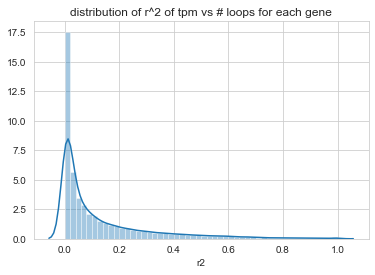

In [181]:
corr_df_filt = corr_df[corr_df.r!=0]
corr_df_filt['r2'] = corr_df_filt.r.apply(lambda x: x**2)
print(corr_df_filt.r2.describe())
ax = sns.distplot(corr_df_filt.r2)
ax.set_title('distribution of r^2 of tpm vs # loops for each gene')
plt.savefig(os.path.join(save_dir, 'corr_df_filt_dist.pdf'))

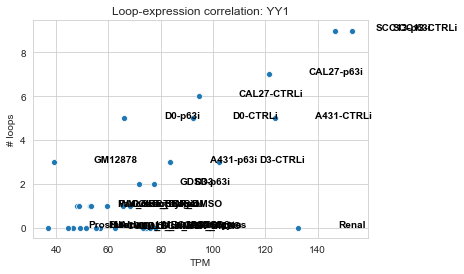

In [174]:
# df_sel = get_scatter_gene('NFATC1',get_text=True)
# df_sel = get_scatter_gene('FOSB',get_text=True)
# df_sel = get_scatter_gene('ADAMTS13',get_text=True)
# df_sel = get_scatter_gene('ABCA1',get_text=True)
# df_sel = get_scatter_gene('PRMT1',get_text=True)
# df_sel = get_scatter_gene('SOX9',get_text=True)
# df_sel = get_scatter_gene('YY1',get_text=True)


In [184]:
genes = corr_df_filt[(corr_df_filt.r2<.8)&(corr_df_filt.r2>.5)].gene.sort_values().values
print(len(genes))
for x in genes:
    print(x)
#     df_sel = get_scatter_gene(x,get_text=True)

802
A4GNT
ABCA9
ABCC5
ABHD12
ABHD2
ABTB2
ACAT2
ACE2
ACTN4
ACVR1C
ADA
ADAM8
ADAMTS10
ADAMTS12
ADARB2
ADCY7
ADD2
ADPRHL1
ADRA2C
AFAP1
AFAP1L2
AGFG2
AGMO
AGO1
AGR3
AHCYL2
AHR
AK2
AK5
AKAP6
AKT2
ALDH3B1
ALOX15
AMDHD1
AMFR
AMOT
AMPH
ANKRD44
ANKRD7
ANO2
ANO3
ANO4
AP5S1
APCDD1L
APCS
APH1A
APOBEC1
APOBR
APOL1
APOL6
AQP2
ARHGAP24
ARHGAP5
ARHGAP9
ARHGEF11
ARID1A
ARL14
ATP1A3
ATP6V0A4
ATP6V1G1
ATP8B1
ATXN10
AURKC
B3GALNT1
B4GALT6
BAALC
BAG5
BAK1
BANP
BCKDHA
BCL2A1
BCL2L11
BCL7B
BIN3
BMP4
BPIFB1
BRF1
BRMS1
BTN3A1
BTN3A2
BTNL9
BVES
CA8
CACNA1I
CACNA2D4
CACNG6
CACNG8
CACTIN
CAGE1
CALCR
CAMK2G
CAMK2N1
CAMK4
CAPN1
CAPN13
CAPN9
CAPSL
CASP4
CASS4
CAT
CBX7
CBY1
CCDC102B
CCDC120
CCDC141
CCDC69
CCDC80
CCDC84
CCDC88C
CCDC97
CCNL1
CCP110
CCR5
CCR9
CD1A
CD79B
CDH23
CDH3
CDK2AP2
CDO1
CELA3B
CEP85L
CFL1
CHCHD2
CHMP3
CHMP4B
CHRNE
CHST1
CIDEB
CIZ1
CKS1B
CLCN1
CLDN16
CLDN23
CLEC7A
CLECL1
CLIP4
CLN3
CLRN1
COL22A1
COL2A1
COLGALT2
COMMD5
COMMD9
COX17
COX19
COX6B2
COX8A
CPA6
CPNE1
CPZ
CRB1
CREB1
CRNKL1
CTCFL
CTDNEP1
C